In [1]:
import os, sys
import copy
import json
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays

with Deep Learning
#### Training
We use the ChestX-ray14 dataset released by Wang
et al. (2017) which contains 112,120 frontal-view X-ray
images of 30,805 unique patients. Wang et al. (2017)
annotate each image with up to 14 different thoracic
pathology labels using automatic extraction methods

on radiology reports. We label images that have pneu-
monia as one of the annotated pathologies as positive

examples and label all other images as negative exam-
ples. For the pneumonia detection task, we randomly

split the dataset into training (28744 patients, 98637
images), validation (1672 patients, 6351 images), and
test (389 patients, 420 images). There is no patient
overlap between the sets.

Before inputting the images into the network, we
downscale the images to 224×224 and normalize based
on the mean and standard deviation of images in the
ImageNet training set. We also augment the training
data with random horizontal flipping.


#### Test
We collected a test set of 420 frontal chest X-rays. An-
notations were obtained independently from four prac-
ticing radiologists at Stanford University, who were

asked to label all 14 pathologies in Wang et al. (2017).

The radiologists had 4, 7, 25, and 28 years of experi-
ence, and one of the radiologists is a sub-specialty fel-
lowship trained thoracic radiologist. Radiologists did

not have access to any patient information or knowl-
edge of disease prevalence in the data. Labels were

entered into a standardized data entry program.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Prepare the data

In [3]:
data_dir = '../../data/processed'
data_filepath = f'{data_dir}/imgs_data01.csv'
round_number = 1

# metadata_filepath = f'{data_dir}/metadata.json'
# with open(metadata_filepath, 'r') as rfile:
#     data = rfile.read()
# metadata = json.loads(data)
# metadata

In [4]:
class ChestXrayDataSet(Dataset):
    def __init__(self, data_filepath, split, round_number):
        self.split = split
        self.round_number = round_number
        dataframe = pd.read_csv(data_filepath)
        dataframe['target'] = dataframe["class label"].apply(lambda x: 0 if x == 'No Finding' else 1)
        self.dataframe = dataframe[((dataframe['split'] == split) 
                                    & (dataframe['round_number'] <= round_number))].reset_index(drop=True)

        self.image_paths = self.dataframe["img_filepath"].values
        self.targets = torch.FloatTensor(self.dataframe['target'].values)
        self.CLASSES_LABELS = ['Healthy', 'Sick']
        self.TARGET_DICT = {self.CLASSES_LABELS[i]: i for i in range(len(self.CLASSES_LABELS))}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(),
        ])
        image = preprocess(image)

        return image, self.targets[index]

In [5]:
train_set = ChestXrayDataSet(data_filepath, 'train', round_number)
valid_set = ChestXrayDataSet(data_filepath, 'valid', round_number)
test_set = ChestXrayDataSet(data_filepath, 'test', round_number)

print('train_set size:', train_set.__len__())
print('valid_set size:', valid_set.__len__())
print('test_set size:', test_set.__len__())
print('total:', train_set.__len__() + valid_set.__len__() + test_set.__len__())

train_set size: 5576
valid_set size: 1634
test_set size: 1661
total: 8871


In [6]:
# Setting the dataloaders:
train_dl = DataLoader(train_set, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=1, shuffle=False)
test_dl = DataLoader(test_set, batch_size=1, shuffle=False)

dataloaders = {'train': train_dl, 'valid': valid_dl, 'test': test_dl}

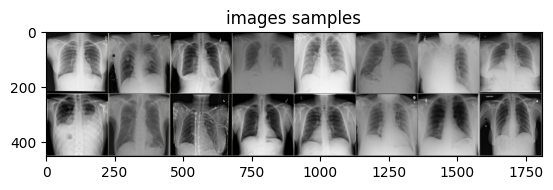

In [7]:
### Visualize a few images
# Let's visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='images samples')

## Set the Model

In [8]:
class DenseNet121(nn.Module):
    def __init__(self, n_classes=1, finetune=False):
        super(DenseNet121, self).__init__()
        self.model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
        for param in self.model.parameters():
            param.requires_grad = finetune
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
model = DenseNet121(n_classes=1, finetune=True)
model = model.to(device)

## Train the model

In [10]:
def train_model(model, dataloaders, device,
                criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model_hist = []

    for epoch in range(num_epochs):
        since_epoch = time.time()
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        epoch_perf = {'epoch': epoch}
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_samples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                n_samples += len(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _, preds = torch.max(outputs, 1)
                    preds = outputs.round()
                    loss = criterion(outputs, labels.reshape(len(labels), 1))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.reshape(len(preds)) == labels.data)

            epoch_loss = running_loss / n_samples
            epoch_acc = running_corrects.double() / n_samples
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            epoch_perf[f'{phase}_loss'] = epoch_loss
            epoch_perf[f'{phase}_acc'] = epoch_acc
            if phase == 'train':
                scheduler.step(epoch_loss)
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        model_hist.append(epoch_perf)
        time_elapsed_epoch = time.time() - since_epoch
        print(f'{time_elapsed_epoch // 60:.0f}m {time_elapsed_epoch % 60:.0f}s/epoch\n')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, pd.DataFrame(model_hist)

In [11]:
num_epochs = 25

criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # RMSprop, Adam
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [12]:
model, model_hist = train_model(model, dataloaders, device,
                                criterion, optimizer, exp_lr_scheduler,
                                num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.6785 Acc: 0.5942
valid Loss: 0.7079 Acc: 0.5936
3m 1s/epoch

Epoch 1/24
----------
train Loss: 0.6671 Acc: 0.6121
valid Loss: 0.6402 Acc: 0.6377
3m 12s/epoch

Epoch 2/24
----------
train Loss: 0.6644 Acc: 0.6058
valid Loss: 0.6485 Acc: 0.6328
3m 23s/epoch

Epoch 3/24
----------
train Loss: 0.6517 Acc: 0.6324
valid Loss: 0.6627 Acc: 0.6065
3m 40s/epoch

Epoch 4/24
----------
train Loss: 0.6443 Acc: 0.6388
valid Loss: 0.6407 Acc: 0.6408
3m 42s/epoch

Epoch 5/24
----------
train Loss: 0.6469 Acc: 0.6410
valid Loss: 0.6331 Acc: 0.6438
4m 0s/epoch

Epoch 6/24
----------
train Loss: 0.6375 Acc: 0.6571
valid Loss: 0.6622 Acc: 0.6230
4m 23s/epoch

Epoch 7/24
----------
train Loss: 0.6378 Acc: 0.6445
valid Loss: 0.6883 Acc: 0.5679
3m 16s/epoch

Epoch 8/24
----------
train Loss: 0.6310 Acc: 0.6548
valid Loss: 0.6412 Acc: 0.6408
2m 45s/epoch

Epoch 9/24
----------
train Loss: 0.6319 Acc: 0.6510
valid Loss: 0.6341 Acc: 0.6438
2m 49s/epoch

Epoch 10/24
----------

In [13]:
def plot_model_hist(historic, title=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.title(title+' loss')
    plt.plot(historic['train_loss'], label='train loss')
    plt.plot(historic['valid_loss'], label='valid. loss')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.title(title+' acc')
    plt.plot(historic['train_acc'], label='train acc')
    plt.plot(historic['valid_acc'], label='valid. acc')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.show()

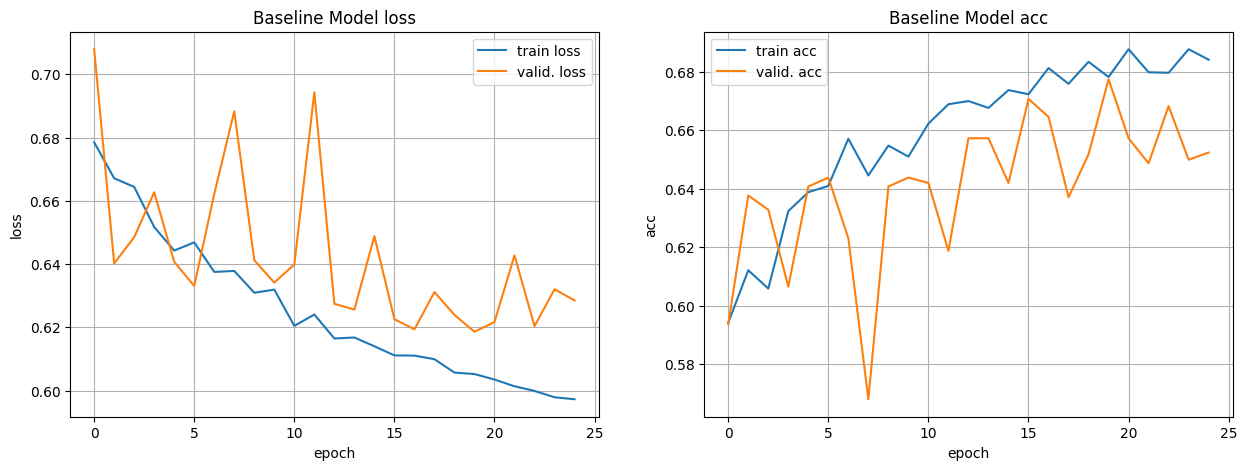

In [14]:
plot_model_hist(model_hist, 'Baseline Model')

## Evaluate model predictions

In [15]:
def evaluate_model(model, dataloaders, split='test'):
    model.eval()
    running_corrects = 0
    n_samples = 0
    for i, (inputs, labels) in enumerate(dataloaders[split]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        n_samples += len(labels)
        
        outputs = model(inputs)
        # _, preds = torch.max(outputs, 1)
        preds = outputs.round()
        running_corrects += torch.sum(preds.reshape(len(preds)) == labels.data)

    eval_acc = running_corrects.double() / n_samples
    print(f'Accuracy on {split} set: %.3f' % eval_acc)
    
evaluate_model(model, dataloaders, split='test')

Accuracy on test set: 0.654


## Saving current model:

In [16]:
db_number = data_filepath.split('/')[-1].split('.')[0].replace('imgs_data', '')
now_ = datetime.now()
model_tag = f'db{db_number}_round{round_number}_{now_.year}-{now_.month}-{now_.day} {now_.hour}h{now_.minute}m{now_.second}s'
modelpath = f'./{model_tag}.pth'
torch.save(model.state_dict(), modelpath)
print(f'{modelpath} saved')

./db01_round1_2022-9-28 0h40m43s.pth saved
